In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3419_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4176_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3370_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1255_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/660_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/484_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/4221_right.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2396_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/543_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/3017_left.jpg
/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1482_left.jpg
/kaggle/input/ocular-disease-recognit

In [2]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [3]:
df.O.value_counts()

0    4804
1    1588
Name: O, dtype: int64

In [4]:
print(df['Left-Diagnostic Keywords'].nunique())

196


In [5]:
df.shape

(6392, 19)

In [6]:
def has_other(text):
    if ('macular epiretinal membrane') in text:
        return 1
    else:
        return 0

In [7]:
df["left_other"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_other(x))
df["right_other"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_other(x))

In [8]:
left_other = df.loc[(df.O ==1) & (df.left_other == 1)]["Left-Fundus"].values
left_other[:15]

array(['4_left.jpg', '6_left.jpg', '37_left.jpg', '40_left.jpg',
       '73_left.jpg', '99_left.jpg', '100_left.jpg', '110_left.jpg',
       '123_left.jpg', '130_left.jpg', '150_left.jpg', '182_left.jpg',
       '207_left.jpg', '221_left.jpg', '256_left.jpg'], dtype=object)

In [9]:
len(left_other)

162

In [10]:
right_other = df.loc[(df.O ==1) & (df.right_other == 1)]["Right-Fundus"].values
right_other[:15]

array(['14_right.jpg', '27_right.jpg', '33_right.jpg', '40_right.jpg',
       '64_right.jpg', '83_right.jpg', '88_right.jpg', '130_right.jpg',
       '134_right.jpg', '140_right.jpg', '143_right.jpg', '156_right.jpg',
       '163_right.jpg', '169_right.jpg', '190_right.jpg'], dtype=object)

In [11]:
len(right_other)

214

In [12]:
print("Number of images in left Other diseases/abnormalities: {}".format(len(left_other)))
print("Number of images in right Other diseases/abnormalities: {}".format(len(right_other)))

Number of images in left Other diseases/abnormalities: 162
Number of images in right Other diseases/abnormalities: 214


In [13]:
left_normal = df.loc[(df.O ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(165,random_state=42).values
right_normal = df.loc[(df.O ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(165,random_state=42).values
right_normal[:15]

array(['2762_right.jpg', '3419_right.jpg', '2701_right.jpg',
       '3285_right.jpg', '2425_right.jpg', '2919_right.jpg',
       '4269_right.jpg', '2712_right.jpg', '2767_right.jpg',
       '2561_right.jpg', '3258_right.jpg', '3228_right.jpg',
       '2554_right.jpg', '2626_right.jpg', '84_right.jpg'], dtype=object)

In [14]:
other = np.concatenate((left_other,right_other),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [15]:
print(len(other),len(normal))

376 330


In [16]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [17]:
dataset = create_dataset(other,1)

100%|██████████| 376/376 [00:02<00:00, 135.60it/s]


In [18]:
dataset = create_dataset(normal,0)

100%|██████████| 330/330 [00:03<00:00, 97.05it/s] 


In [19]:
len(dataset)

700

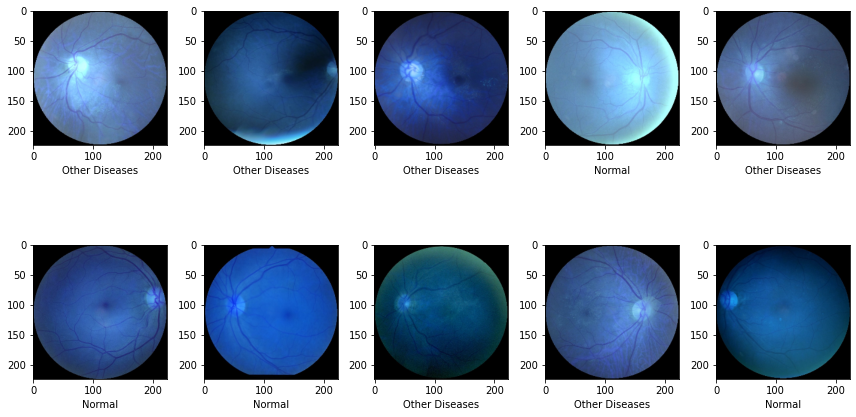

In [20]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Other Diseases"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [21]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [22]:
print(x.shape)
print(y.shape)

(700, 224, 224, 3)
(700,)


In [23]:
# Get the Barchat
gt_t = []
for g in y:
    if g == 0:
        gt_t.append("Normal")
    else:
        gt_t.append("Other Diseases")
        
gt_t = np.array(gt_t)

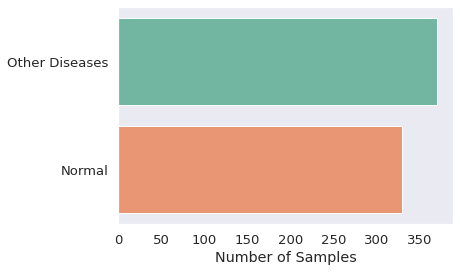

In [24]:
import seaborn as sns
sns.set(style="dark", font_scale=1.2)
ax = sns.countplot(y=gt_t, palette="Set2")

ax.set(xlabel='Number of Samples')
plt.grid(False)
plt.show()

In [25]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

In [26]:
print(f'x_train',x_train.shape)
print(f'x_test',x_test.shape)
print(f'y_train',y_train.shape)
print(f'y_test',y_test.shape)

x_train (490, 224, 224, 3)
x_test (210, 224, 224, 3)
y_train (490,)
y_test (210,)


In [27]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

2021-10-27 08:17:09.751948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 08:17:09.841122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 08:17:09.841850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 08:17:09.843112: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step


In [28]:
for layer in vgg.layers:
    layer.trainable = False

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
model = Sequential()
model.add(vgg)
model.add(Dropout(0.1))
#model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [31]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [33]:
history = model.fit(x_train,y_train,batch_size=32,epochs=20,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

2021-10-27 08:17:14.145938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-10-27 08:17:15.687554: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


16/16 [==============================] - 14s 306ms/step - loss: 5.7985 - accuracy: 0.5265 - val_loss: 3.3992 - val_accuracy: 0.6143
Epoch 2/20
16/16 [==============================] - 2s 101ms/step - loss: 1.8671 - accuracy: 0.7735 - val_loss: 1.9972 - val_accuracy: 0.7190
Epoch 3/20
16/16 [==============================] - 2s 104ms/step - loss: 0.8065 - accuracy: 0.8633 - val_loss: 1.9293 - val_accuracy: 0.7476
Epoch 4/20
16/16 [==============================] - 2s 101ms/step - loss: 0.2390 - accuracy: 0.9306 - val_loss: 0.9461 - val_accuracy: 0.8524
Epoch 5/20
16/16 [==============================] - 2s 101ms/step - loss: 0.1154 - accuracy: 0.9714 - val_loss: 0.7768 - val_accuracy: 0.8619
Epoch 6/20
16/16 [==============================] - 2s 102ms/step - loss: 0.1343 - accuracy: 0.9592 - val_loss: 0.9028 - val_accuracy: 0.8667
Epoch 7/20
16/16 [==============================] - 2s 102ms/step - loss: 0.0590 - accuracy: 0.9694 - val_loss: 0.8625 - val_accuracy: 0.8857
Epoch 8/20
16/16

In [34]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 1s 71ms/step - loss: 1.0927 - accuracy: 0.8619
loss: 1.0927056074142456
Accuracy: 0.8619047403335571


In [35]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

In [36]:
accuracy_score(y_test,y_pred)

0.861904761904762

In [37]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84       102
           1       0.80      0.98      0.88       108

    accuracy                           0.86       210
   macro avg       0.89      0.86      0.86       210
weighted avg       0.88      0.86      0.86       210



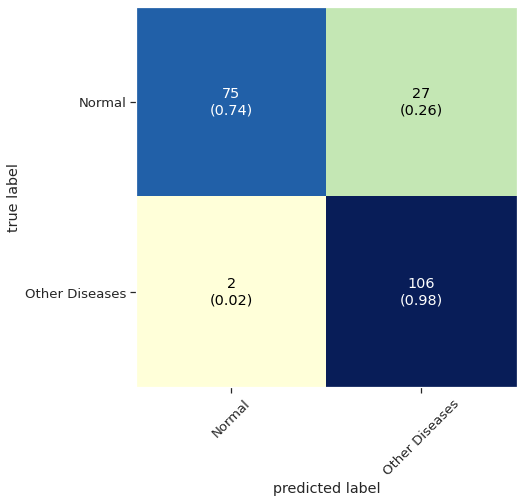

In [38]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Other Diseases"],
                      show_normed = True, cmap ='YlGnBu');

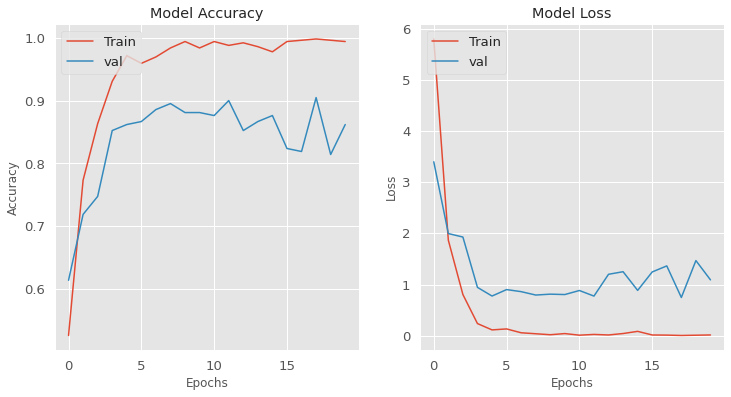

In [39]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

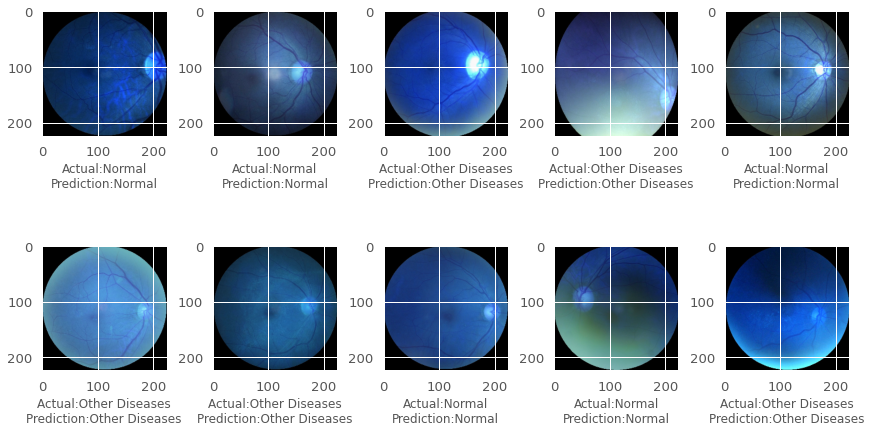

In [40]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Other Diseases"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Other Diseases"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 